In [1]:
import pandas as pd
import numpy as np
import os
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.simplefilter(action='ignore', category='SettingWithCopyWarning')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
folder_path = r'D:\Datasets'

business_file = 'yelp_academic_dataset_business.csv'
business_path = os.path.join(folder_path, business_file)

df = pd.read_csv(business_path, nrows=10000)

In [2]:
df.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [3]:
content_data = df[['business_id', 'name', 'categories', 'attributes', 'stars', 'review_count']].copy()

# Set type to string
content_data['categories'] = content_data['categories'].astype(str)
content_data['attributes'] = content_data['attributes'].astype(str)

# handle missing values
content_data['categories'].fillna('', inplace=True)
content_data['attributes'].fillna('', inplace=True)

# make a new column called 'content'
content_data['content'] = content_data['name'] + ' ' + content_data['categories'] + ' ' + content_data['attributes']

In [4]:
# TF-IDF to convert text into numerical vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(content_data['content'])

# Calculate cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [5]:
def get_content_recommendations(name, cosine_sim=cosine_sim, content_data=content_data, threshold=0.1):

    # get index of the restaurent
    idx = content_data.index[content_data['name'] == name].tolist()
    if not idx:
        print(f"No restuarents found with name '{name}'")
        return []

    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # filter out items with similarity below the threshold
    sim_scores = [(i, score) for i, score in sim_scores if score > threshold]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get top 10 similar restaurents
    top_similar_restaurents = sim_scores[1:11]
    
    # Get the indices and names of the top similar restaurents
    similar_indices = [i[0] for i in top_similar_restaurents]
    similar_restaurents = content_data.iloc[similar_indices][['name', 'review_count', 'stars']]
    return similar_restaurents

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation Metrics

In [7]:
# Evaluation Metrics
def evaluate_recommendations(actual_restaurents, recommended_restaurents):
    recommended_set = set(recommended_restaurents['name'])
    actual_set = set(actual_restaurents['name'])
    precision = len(recommended_set.intersection(actual_set)) / len(recommended_set)
    recall = len(recommended_set.intersection(actual_set)) / len(actual_set)
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

# Cross-Validation

In [8]:
kf = KFold(n_splits=5)

# Visualization

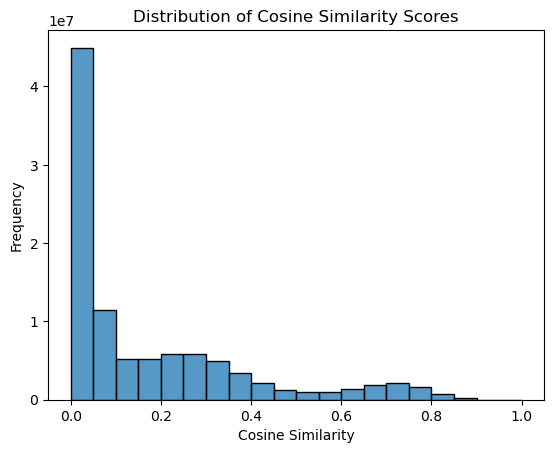

In [9]:
# Visualizing the distribution of similarity scores
sns.histplot(cosine_sim.flatten(), bins=20)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarity Scores')
plt.show()

# Example Usage

In [7]:
restaurent_name = "St Honore Pastries"
content_recommendations = get_content_recommendations(restaurent_name, threshold=0.5)

print(f"Content-Based Recommendations for {restaurent_name}:")
print(content_recommendations)

Content-Based Recommendations for St Honore Pastries:
                           name  review_count  stars
9362  Chatime - Bubble Tea Cafe           182    3.5
9466                  Starbucks            53    3.0
2732                  Starbucks            31    3.5
8101                  Starbucks            18    2.5
2926                Eleven Cafē            21    5.0
9013                  Starbucks            15    4.0
4424                  Starbucks             5    4.0
8398                  Starbucks            17    3.5
8995                  Starbucks            65    3.0
6392                  Starbucks            17    1.5


In [8]:
restaurent_name = "Tuna Bar"
content_recommendations = get_content_recommendations(restaurent_name, threshold=0.5)

print(f"Content-Based Recommendations for {restaurent_name}:")
print(content_recommendations)

Content-Based Recommendations for Tuna Bar:
                                        name  review_count  stars
151                                  J Sushi            72    4.5
2012                               Sushi Bar           346    4.0
275                               Sake House           140    3.0
1635                        Kampai Sushi Bar           328    4.0
221   Tomo Japanese Steakhouse and Sushi Bar           246    4.0
3276                              Sushi Nara           159    4.5
3685                           Samurai Sushi           367    4.0
1614                           Sachiko Sushi           191    3.5
9202                                 Ichiban           227    3.5
6077                              Sushi Ushi           256    4.5


In [9]:
restaurent_name = "The Waterwheel"
content_recommendations = get_content_recommendations(restaurent_name, threshold=0.5)

print(f"Content-Based Recommendations for {restaurent_name}:")
print(content_recommendations)

No restuarents found with name 'The Waterwheel'
Content-Based Recommendations for The Waterwheel:
[]
